In [255]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error

# 1. Data Preparation

In [220]:
# import dataset number 1
pokemon = pd.read_csv('pokemon.csv')

In [221]:
# import dataset number 2
combats = pd.read_csv('combats.csv')

In [222]:
# Fill the missing Name for Pokemon #62 (Primeape)
pokemon['Name'] = pokemon['Name'].fillna('Primeape')

In [223]:
# Handle NaN values in Type 2 (mark as “None” if missing)
pokemon['Type 2'] = pokemon['Type 2'].fillna('None')

In [224]:
# we need to calculate each Pokemon’s win percentage using the combat data:
## we need total number of wins
## we need total number of combats
## after we need to divide total wins / total combats

In [225]:
# total number of wins
wins = combats['Winner'].value_counts().rename_axis('#').reset_index(name='Wins')

In [226]:
# total number of combats
first = combats['First_pokemon'].value_counts()
second = combats['Second_pokemon'].value_counts()

participations = (first + second).rename_axis('#').reset_index(name='Battles')
participations['Battles'] = participations['Battles'].fillna(0) # if didn`t participate

In [227]:
# add name # for index
combats = combats.rename_axis('#')

In [228]:
# merge wins, participations woth pokemon dataset
poke = pokemon.merge(wins, on='#', how='left')
poke = poke.merge(participations, on='#', how='left')
poke = poke.merge(combats, on='#', how='left')

In [229]:
# fill NaN
poke['Wins'] = poke['Wins'].fillna(0)
poke['Battles'] = poke['Battles'].fillna(0)

In [230]:
# the first 5 rows of new dataset
poke.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Battles,First_pokemon,Second_pokemon,Winner
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,133.0,702,701,701
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,121.0,191,668,668
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,132.0,237,683,683
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70.0,125.0,151,231,151
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,55.0,112.0,657,752,657


In [231]:
# Calculate each Pokemon’s win percentage using the combat data.
poke['Win_Percent'] = ((poke['Wins'] / poke['Battles']) * 100).round(1)
poke['Win_Percent'] = poke['Win_Percent'].fillna(0)

In [232]:
# check percentege
poke.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Battles,First_pokemon,Second_pokemon,Winner,Win_Percent
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,133.0,702,701,701,27.8
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,121.0,191,668,668,38.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,132.0,237,683,683,67.4
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70.0,125.0,151,231,151,56.0
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,55.0,112.0,657,752,657,49.1


# 2. Exploratory Analysis & Visualization

In [233]:
# preparation for correlation matrix

needed_col = ['HP', 'Attack', 'Speed', 'Win_Percent']

corr_matrix = poke[needed_col]

In [234]:
# calculate correlation matrix
correlation_matrix = corr_matrix.corr(numeric_only = True)

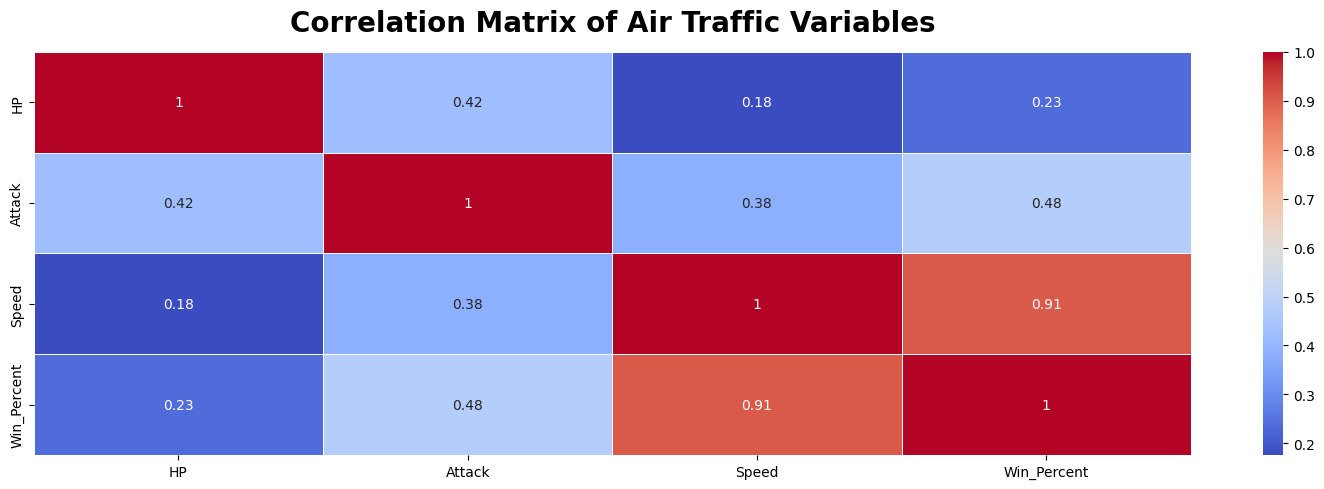

In [235]:
# plot correlation matrix
plt.figure(figsize = (15,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix of Air Traffic Variables', fontweight = 'bold', fontsize = 20, pad = 15)
plt.tight_layout()

plt.show()

---
**Conclusion for correlation matrix**:
- The analysis reveals that Win Percentage exhibits the strongest correlation with the Speed attribute. This finding implies that Speed serves as the primary contributing factor determining a Pokemon's success in combat.

- Although the correlation observed with the remaining parameters is comparatively weaker, it remains statistically significant and cannot be disregarded.
***

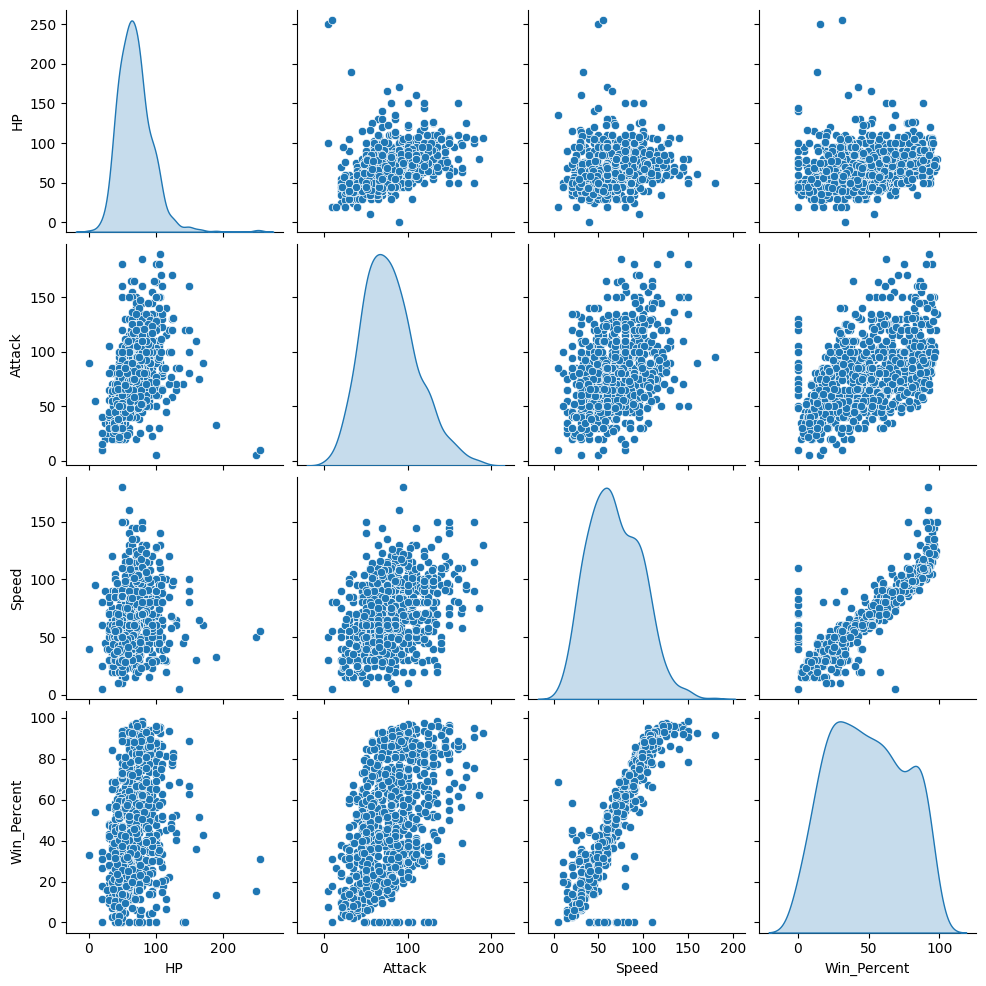

In [236]:
# Plot a Seaborn pairplot or PairGrid for stats vs. win percentage.

sns.pairplot(poke[needed_col], diag_kind='kde')
plt.show()

---
**Conclusions for Seaborn pairplot**:
- Speed vs. Win_Percent: The dots are very closely aligned along an ascending line (close to a diagonal). This confirms the previous observation: Speed has the strongest positive correlation with Win Percentage.

- Attack vs. Win_Percent: The relationship is also positive (rising), but the dots are more dispersed than with Speed. There is a correlation, but it is weaker.

- HP vs. Win_Percent: The dots are most dispersed across the entire area. The relationship is very weak or nonexistent.
---

In [237]:
# Analyze the top 10 Pokemon by win percentage and their stats.
first_ten_win = poke.sort_values('Win_Percent', ascending = False).head(10)

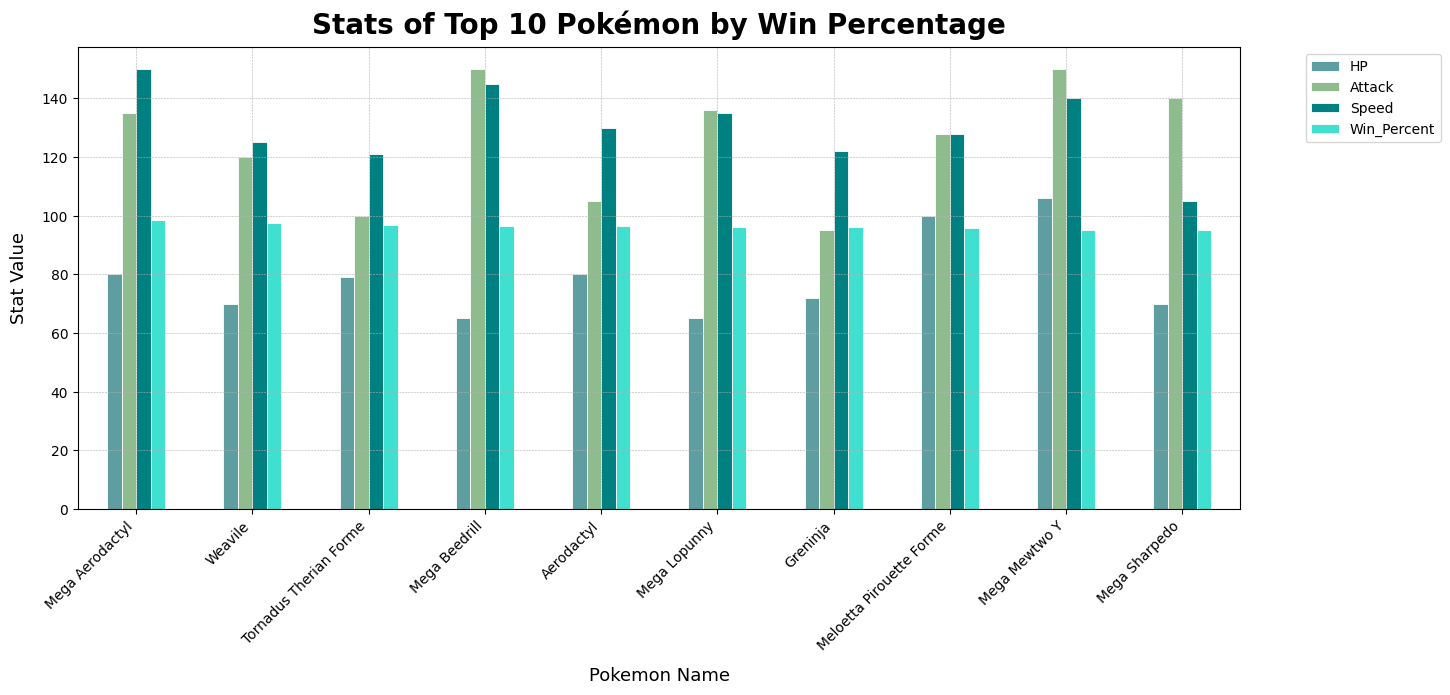

In [238]:
first_ten_win.set_index('Name')[needed_col].plot(kind='bar', figsize=(15,6), color = ['cadetblue', 'darkseagreen', 'teal',  'turquoise'], edgecolor = 'white', linewidth = 0.6)
plt.title('Stats of Top 10 Pokémon by Win Percentage', fontsize = 20, fontweight = 'bold', pad = 10)
plt.xlabel('Pokemon Name', fontsize = 13, labelpad = 10)
plt.ylabel("Stat Value", fontsize = 13, labelpad = 10)
plt.xticks(rotation=45, ha='right')

plt.grid(linewidth = 0.4, linestyle = '--')

ax = plt.gca()
ax.legend(
    loc='upper left',                  
    bbox_to_anchor=(1.05, 1) 
)


plt.show()

---
Looking at the statistics of the top ten Pokémon with the highest win rates (Top 10) clearly shows that their Attack stat is also exceptionally high, making it critical to achieving maximum success.
***

# 3. Machine Learning

In [239]:
# drop columns that we don`t need
#	Name irst_pokemon	Second_pokemon	Winner
drop_col = ['#', 'Name', 'First_pokemon', 'Second_pokemon',	'Winner']
poke = poke.drop(drop_col, axis = 1)

In [240]:
# OHE for category columns

poke = pd.get_dummies(poke, columns = ['Type 1', 'Type 2', 'Legendary'], drop_first = True)

In [241]:
# define target feature
y = poke['Win_Percent']

In [242]:
# drop target feature from dataset
poke = poke.drop('Win_Percent', axis = 1)

In [243]:
# define X
X = poke

In [244]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [245]:
# Standard Scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [249]:
# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

y_pred_lr = model_lr.predict(X_test_scaled)

In [251]:
# Random Forest
model_rf = RandomForestRegressor(n_estimators = 200, random_state = 42)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

In [254]:
# XGBoost
model_xgb = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.5,
    max_depth = 5,
    subsample = 0.8,
    colsample_bytree = 0.8
)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

In [263]:
# Compare model performance using Mean Absolute Error (MAE)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f'''Mean Absolute Error (MAE) by different regression models
{'=' * 57}
Linear Regression | {mae_lr:.2f}
Random Forest     | {mae_rf:.2f}
XGBoost           | {mae_xgb:.2f}
''')

Mean Absolute Error (MAE) by different regression models
Linear Regression | 2.85
Random Forest     | 1.31
XGBoost           | 1.67



---
Random Forest shows the lowest MAE, that is why this model is the best to predict win percentage.
***